In [1]:
import sys
sys.path.append('.conda/envs/shear/lib/python3.9/site-packages/')

import numpy as np
import astropy.io.fits as pf
from astropy.table import Table, vstack
import pylab as mplot
import yaml
import h5py
import healpy as hp
# import healsparse as hs
import scipy
from scipy import interpolate

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/chihway/.conda/envs/shear/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['vstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Instructions

This notebook is excecuted after the metacal/gold combined catalog is generated, it will
* add a s/g classification column
* add a foreground mask column
* calculate weights and add column

then store it back to the same file. These steps should just need to be executed once, then can be commented out.

It will then
* calculate some rough estimate of number counts with different cuts are area
* calculate the shear response after the fiducial cuts
* make some maps from the metacal catalog and store in healpix maps

In [2]:
tag = '1212'
project_dir = '/project/chihway/data/decade/'

In [5]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:

    print(h5r.keys())

<KeysViewHDF5 ['DEC', 'FLUXERR_AUTO_G', 'FLUXERR_AUTO_I', 'FLUXERR_AUTO_R', 'FLUXERR_AUTO_Z', 'FLUX_AUTO_G', 'FLUX_AUTO_I', 'FLUX_AUTO_R', 'FLUX_AUTO_Z', 'FLUX_RADIUS_G', 'FLUX_RADIUS_I', 'FLUX_RADIUS_R', 'FLUX_RADIUS_Z', 'Ncutouts_raw', 'RA', 'badfrac', 'id', 'mcal_T_1m', 'mcal_T_1p', 'mcal_T_2m', 'mcal_T_2p', 'mcal_T_noshear', 'mcal_T_ratio_1m', 'mcal_T_ratio_1p', 'mcal_T_ratio_2m', 'mcal_T_ratio_2p', 'mcal_T_ratio_noshear', 'mcal_flags', 'mcal_flux_1m', 'mcal_flux_1p', 'mcal_flux_2m', 'mcal_flux_2p', 'mcal_flux_err_1m', 'mcal_flux_err_1p', 'mcal_flux_err_2m', 'mcal_flux_err_2p', 'mcal_flux_err_noshear', 'mcal_flux_noshear', 'mcal_g_1m', 'mcal_g_1p', 'mcal_g_2m', 'mcal_g_2p', 'mcal_g_cov_1m', 'mcal_g_cov_1p', 'mcal_g_cov_2m', 'mcal_g_cov_2p', 'mcal_g_cov_noshear', 'mcal_g_noshear', 'mcal_psf_T_noshear', 'mcal_psf_g_noshear', 'mcal_s2n_1m', 'mcal_s2n_1p', 'mcal_s2n_2m', 'mcal_s2n_2p', 'mcal_s2n_noshear', 'x', 'y']>


In [4]:
# check that IDs are matched
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:

    id_gold = h5r['COADD_OBJECT_ID'][:]
    id_mcal = h5r['id'][:]
    ra = h5r['RA'][:]
    dec = h5r['DEC'][:]
    e1 = h5r['mcal_T_noshear'][:]

In [5]:
ids = np.arange(len(ra))
np.random.shuffle(ids)

In [6]:
print(np.sum(np.abs(id_gold-id_mcal)))

0


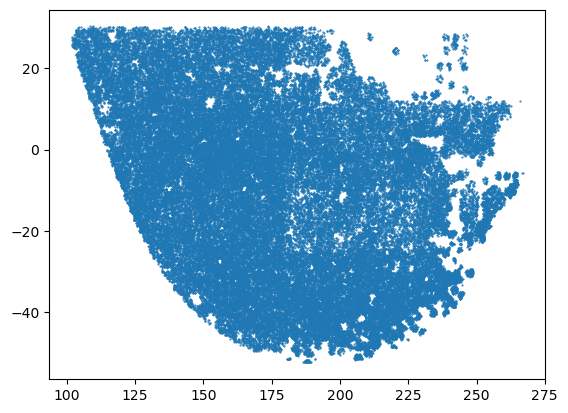

In [7]:
mplot.scatter(ra[ids[:100000]], dec[ids[:100000]], marker='.', s=1)

In [8]:
len(ra)

597650947

### The following adds a s/g column, commented out when it's done

In [9]:
def extProduction(BDF_T, BDF_S2N):
    
    x = [-3.       ,  0.79891862,  0.90845217,  0.98558583,  1.05791208,
         1.13603715,  1.22479487,  1.33572223,  1.48983602,  1.74124395,
         2.43187589,  6.        ] 
    y_1 = [0.028, 0.028, 0.008, 0.   , 0.004, 0.012, 0.012, 0.004, 0.012,
           0.024, 0.04 , 0.04 ]
    y_2 = [-0.028, -0.028, -0.04 , -0.032, -0.036, -0.032, -0.028, -0.016,
           -0.012,  0.008,  0.016,  0.016]
    y_3 = [-0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  ,
           -0.012,  0.008,  0.016,  0.016]
    y_4 = [0.252, 0.252, 0.188, 0.14 , 0.096, 0.104, 0.052, 0.048, 0.04 ,
           0.052, 0.088, 0.088]

    f_array = [scipy.interpolate.interp1d(x, y_1, fill_value=-99, bounds_error=False),
               scipy.interpolate.interp1d(x, y_2, fill_value=-99, bounds_error=False),
               scipy.interpolate.interp1d(x, y_3, fill_value=-99, bounds_error=False),
               scipy.interpolate.interp1d(x, y_4, fill_value=-99, bounds_error=False)]

    x_data = np.log10(BDF_S2N)
    x_data = np.where(np.isfinite(x_data), x_data, x[0])
    y_data = BDF_T.copy()
    ext = np.tile(0, len(x_data))
    for f in f_array:
        selection = (y_data > f(x_data))
        ext += selection.astype(int)
    
    # Sentinel values
    selection = np.isclose(BDF_T, -9.999e+09) | np.isclose(BDF_S2N, -9.999e+09) | (BDF_S2N <= 0.)
    ext[selection] = -9

    return np.where(np.isfinite(ext), ext, -9)

In [10]:
# add new s/g column and mcal cut and store it back
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    bdf_s2n = h5r['BDF_S2N'][:]
    bdf_t = h5r['BDF_T'][:]
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]

In [11]:
sg_bdf = extProduction(bdf_t, bdf_s2n)

del bdf_s2n
del bdf_t
del size_ratio
del s2n

/home/chihway/ipykernel_254426/2142291224.py:20: RuntimeWarning: divide by zero encountered in log10
  x_data = np.log10(BDF_S2N)
/home/chihway/ipykernel_254426/2142291224.py:20: RuntimeWarning: invalid value encountered in log10
  x_data = np.log10(BDF_S2N)


In [12]:
print('total length', len(sg_bdf))
print('s/g cut 1', len(sg_bdf[sg_bdf>=3]))
print('s/g cut 2', len(sg_bdf[sg_bdf>=4]))

total length 597650947
s/g cut 1 378007948
s/g cut 2 306735988


In [13]:
# with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'a') as h5r:
#     h5r.create_dataset('sg_bdf', data = sg_bdf)


### The following adds a star mask file, commented out when it's done

In [14]:
x = hp.read_map('/project/chihway/dhayaa/DECADE/Gold_Foreground_20230520.fits')
x = x.astype(int)

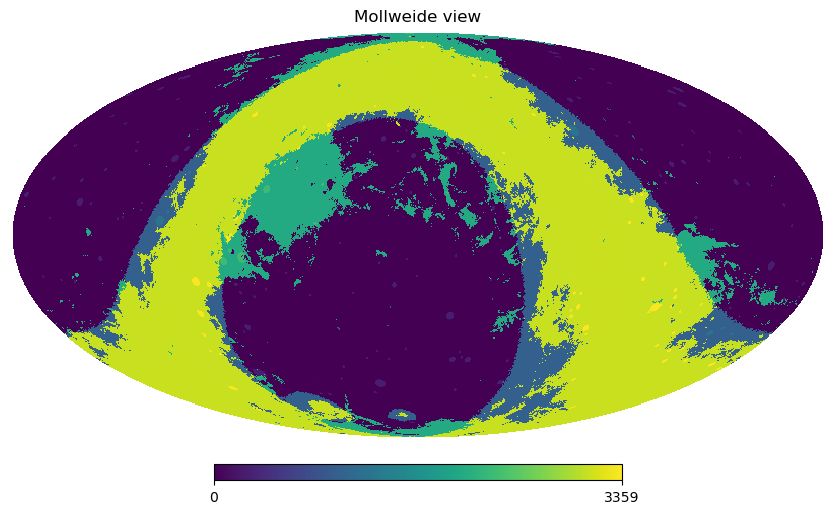

In [15]:
hp.mollview(x)

In [16]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    ra = h5r['RA'][:]
    dec = h5r['DEC'][:]

In [17]:
nside=4096
phi = ra/180*np.pi
theta = (90.-dec)/180*np.pi

pix = hp.ang2pix(nside, theta, phi)
foreground = x[pix]

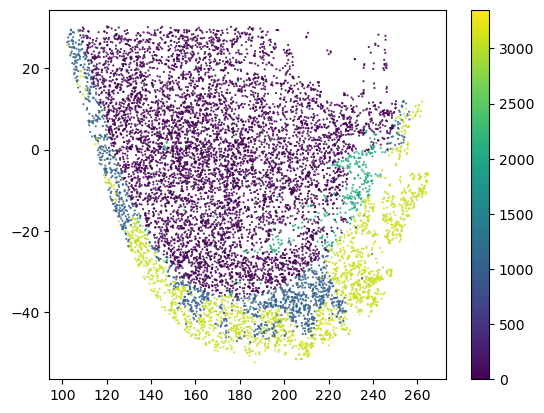

In [18]:
ids = np.arange(len(pix))
np.random.shuffle(ids)
mplot.scatter(ra[ids[:10000]], dec[ids[:10000]], c=foreground[ids[:10000]], marker='.', s=1)
mplot.colorbar()

In [19]:
# with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'a') as h5r:
#      h5r.create_dataset('FLAGS_FOREGROUND', data = foreground)

### Now calculate weights and put in as a column, commented out when it's done

Follow Y6 and do " total shape noise of sample + the measurement error from metacal" instead of the Y3 method of binning the galaxies in size ratio and s/n bins. Note that this can be done uncalibrated since it cancels out when we are interested in relative weights.

In [3]:
# first get mask total

with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    flux_r, flux_i, flux_z = h5r['mcal_flux_noshear'][:].T

mag_r = -2.5*np.log10(flux_r)+30
mag_i = -2.5*np.log10(flux_i)+30
mag_z = -2.5*np.log10(flux_z)+30

# PZ mask
mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                    (mag_r < 26)   & (mag_r > 15) & 
                    (mag_z < 26)   & (mag_z > 15) & 
                    (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                    (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

del flux_r, flux_i, flux_z, mag_i, mag_z


/home/chihway/ipykernel_3703887/2641388271.py:6: RuntimeWarning: invalid value encountered in log10
  mag_r = -2.5*np.log10(flux_r)+30
/home/chihway/ipykernel_3703887/2641388271.py:7: RuntimeWarning: invalid value encountered in log10
  mag_i = -2.5*np.log10(flux_i)+30
/home/chihway/ipykernel_3703887/2641388271.py:8: RuntimeWarning: invalid value encountered in log10
  mag_z = -2.5*np.log10(flux_z)+30


In [4]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:

    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]
    T = h5r['mcal_T_noshear'][:]
    mcal_flags = h5r['mcal_flags'][:]  
    g1, g2  = h5r['mcal_g_noshear'][:].T

# Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
SNR_Mask   = (s2n > 10) & (s2n < 1000)
Tratio_Mask= size_ratio > 0.5
T_Mask = T < 10
Flag_Mask = (mcal_flags == 0)
Other_Mask = np.invert((T > 2) & (s2n < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))

del size_ratio, s2n, T, mcal_flags, g1, g2 


/home/chihway/ipykernel_3703887/4257729409.py:14: RuntimeWarning: invalid value encountered in log10
  Other_Mask = np.invert((T > 2) & (s2n < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))


In [5]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:

#     sg = h5r['sg_bdf'][:] 
    sg = h5r['FLAGS_FOREGROUND'][:]*0.0 + 4
    fg = h5r['FLAGS_FOREGROUND'][:] 

# Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
SG_Mask = (sg>=4)
FG_Mask = (fg==0)

mask_total = mcal_pz_mask & SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Other_Mask & SG_Mask & FG_Mask

del sg, fg 
del mcal_pz_mask, SNR_Mask, Tratio_Mask, T_Mask, Flag_Mask, Other_Mask, SG_Mask

In [23]:
# print('original', len(sg), '('+str(len(sg)/len(sg))+')')
# print('mcal pz mask', len(sg[mcal_pz_mask]), '('+str(len(sg[mcal_pz_mask])/len(sg))+')')
# print('SNR mask', len(sg[SNR_Mask]), '('+str(len(sg[SNR_Mask])/len(sg))+')')
# print('T ratio mask', len(sg[Tratio_Mask]), '('+str(len(sg[Tratio_Mask])/len(sg))+')')
# print('T mask', len(sg[T_Mask]), '('+str(len(sg[T_Mask])/len(sg))+')')
# print('flag mask', len(sg[Flag_Mask]), '('+str(len(sg[Flag_Mask])/len(sg))+')')
# print('other mask', len(sg[Other_Mask]), '('+str(len(sg[Other_Mask])/len(sg))+')')
# print('s/g mask', len(sg[SG_Mask]), '('+str(len(sg[SG_Mask])/len(sg))+')')
# print('foreground mask', len(sg[FG_Mask]), '('+str(len(sg[FG_Mask])/len(sg))+')')
# print('total mask', len(sg[mask_total]), '('+str(len(sg[mask_total])/len(sg))+')')

In [24]:
# first read shear catalog, place fiducial cuts, calibrate as a full sample

with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    mcal_g = h5r['mcal_g_noshear'][:]
    mcal_g_cov = h5r['mcal_g_cov_noshear'][:]
    # note we don't cut on covariance since we need to store it back as one number for all galaxies

In [25]:
e1 = mcal_g[:,0][mask_total] 
e2 = mcal_g[:,1][mask_total] 
print(len(e1))

sig_e_squared = 0.5*(np.sum(e1**2)/len(e1) + np.sum(e2**2)/len(e1))
print('raw shape noise', sig_e_squared, sig_e_squared**0.5)

85757977
raw shape noise 0.03863580350589319 0.19655992344802434


In [26]:
mcal_g1_var_mea = mcal_g_cov[:,0,0] 
mcal_g1_var = mcal_g1_var_mea + sig_e_squared
mcal_g1_w = 1./mcal_g1_var

mcal_g2_var_mea = mcal_g_cov[:,1,1] 
mcal_g2_var = mcal_g2_var_mea + sig_e_squared
mcal_g2_w = 1./mcal_g2_var

In [27]:
# len(mcal_g1_var_mea), len(mask_total)

25.8827281758866


Text(0.5, 1.0, 'weights for g1 and g2')

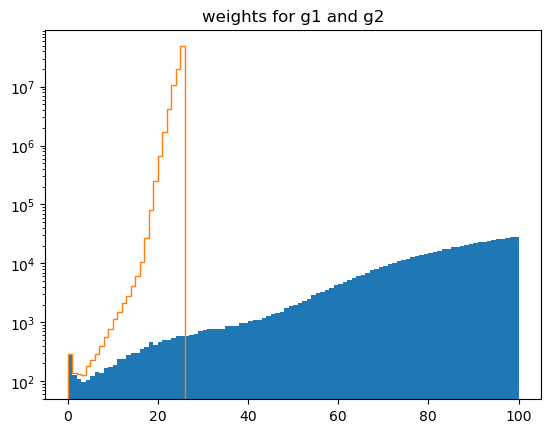

In [28]:
mplot.hist(1./mcal_g1_var_mea[mask_total], bins=100, range=(0.01,100))
mplot.hist(1./(mcal_g1_var_mea[mask_total]+ sig_e_squared), bins=100, range=(0.01,100), histtype='step')

print(1./sig_e_squared)
# mplot.xscale('log')
mplot.yscale('log')

mplot.title('weights for g1 and g2')

Text(0.5, 1.0, 'weights for g1 and g2')

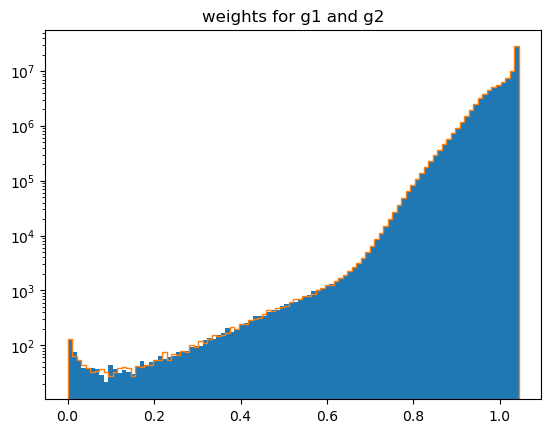

In [29]:
mplot.hist(mcal_g1_w[mask_total]/np.sum(mcal_g1_w[mask_total])*len(mcal_g1_w[mask_total]), bins=100)
mplot.hist(mcal_g2_w[mask_total]/np.sum(mcal_g2_w[mask_total])*len(mcal_g1_w[mask_total]), bins=100, histtype='step')

mplot.yscale('log')
mplot.title('weights for g1 and g2')

In [30]:
with h5py.File('/project/chihway/data/decade/metacal_gold_combined_2023'+tag+'.hdf', 'a') as h5r:
    #      h5r['mcal_g_w'][:] = (mcal_g1_w+mcal_g2_w)/2
     h5r.create_dataset('mcal_g_w', data = (mcal_g1_w+mcal_g2_w)/2)

### Make weight as a function of size/S2N plot 

In [ ]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]


In [ ]:
# determine what grid to use
print(len(s2n), len(s2n[mask_total]), len(s2n[mask_total*(size_ratio>0.5)*(size_ratio<6)*(s2n>10)*(s2n<400)]))
print(len(s2n[mask_total*(size_ratio>0.5)*(size_ratio<6)*(s2n>10)*(s2n<400)])/len(s2n[mask_total]))

In [9]:
size_ratio_grid = np.logspace(np.log10(0.5), np.log10(6), 21)
s2n_grid = np.logspace(np.log10(10), np.log10(400), 21)
size_ratio_grid2 = [str(xx)[:4] for xx in size_ratio_grid]
s2n_grid2 = [str(xx)[:4] for xx in s2n_grid]

In [6]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    w = h5r['mcal_g_w'][:]
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]
    g1, g2  = h5r['mcal_g_noshear'][:].T
    mcal_g_cov = h5r['mcal_g_cov_noshear'][:]

In [7]:
w = w[mask_total]
size_ratio = size_ratio[mask_total]
s2n = s2n[mask_total]
g1 = g1[mask_total]
g2 = g2[mask_total]
mcal_g_cov = mcal_g_cov[mask_total]

In [10]:
weight_grid = np.zeros((20,20))
weight_grid_m = np.zeros((20,20))
e1_grid = np.zeros((20,20))
e2_grid = np.zeros((20,20))
R_grid = np.zeros((20,20))

for i in range(20):
    for j in range(20):
        mask_bin = (size_ratio>=size_ratio_grid[i])*(size_ratio<size_ratio_grid[i+1])*(s2n>=s2n_grid[j])*(s2n<s2n_grid[j+1])
        weight_grid[i][j] = np.mean(w[mask_bin])
        weight_grid_m[i][j] = np.mean(1./mcal_g_cov[:,0,0][mask_bin])
        e1_grid[i][j] = np.sqrt(np.mean(g1[mask_bin]**2))
        e2_grid[i][j] = np.sqrt(np.mean(g2[mask_bin]**2))


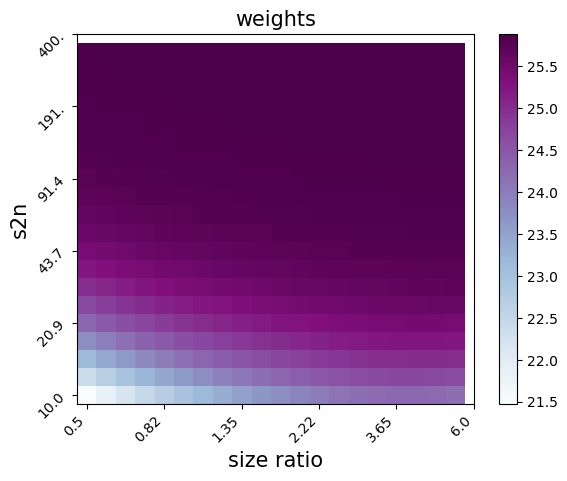

In [11]:
mplot.imshow(weight_grid.T, cmap='BuPu', origin='lower', aspect='auto')
mplot.xticks(np.arange(21)[::4], size_ratio_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.yticks(np.arange(21)[::4], s2n_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.title('weights', fontsize=15)
mplot.xlabel('size ratio', fontsize=15)
mplot.ylabel('s2n', fontsize=15)
mplot.colorbar()

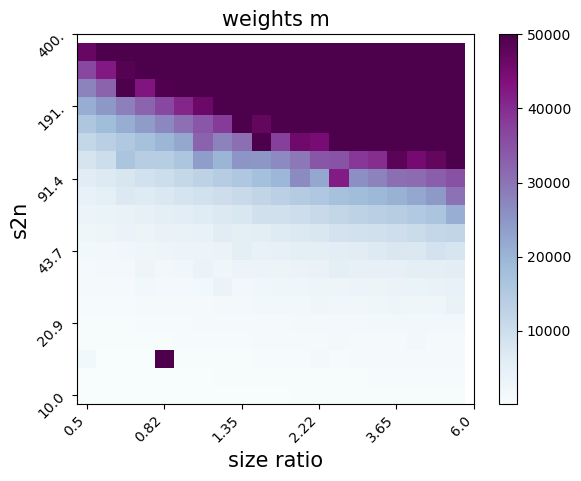

In [12]:
mplot.imshow(weight_grid_m.T, cmap='BuPu', origin='lower', aspect='auto')
mplot.xticks(np.arange(21)[::4], size_ratio_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.yticks(np.arange(21)[::4], s2n_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.title('weights m', fontsize=15)
mplot.xlabel('size ratio', fontsize=15)
mplot.ylabel('s2n', fontsize=15)
mplot.colorbar()
mplot.clim(np.min(weight_grid_m), 50000)

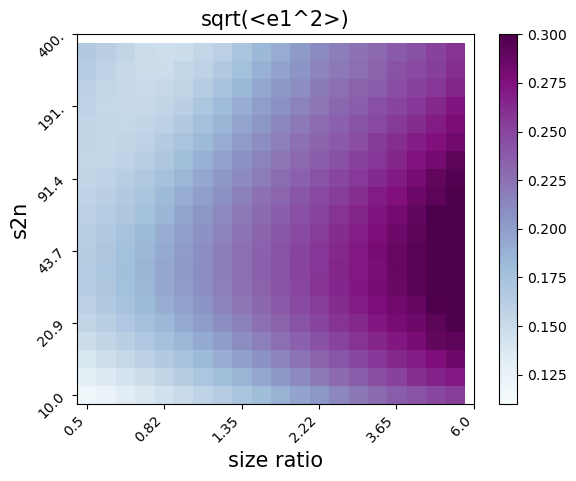

In [13]:
mplot.imshow(e1_grid.T, cmap='BuPu', origin='lower', aspect='auto')
mplot.xticks(np.arange(21)[::4], size_ratio_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.yticks(np.arange(21)[::4], s2n_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.title('sqrt(<e1^2>)', fontsize=15)
mplot.xlabel('size ratio', fontsize=15)
mplot.ylabel('s2n', fontsize=15)
mplot.colorbar()
mplot.clim(0.11,0.3)

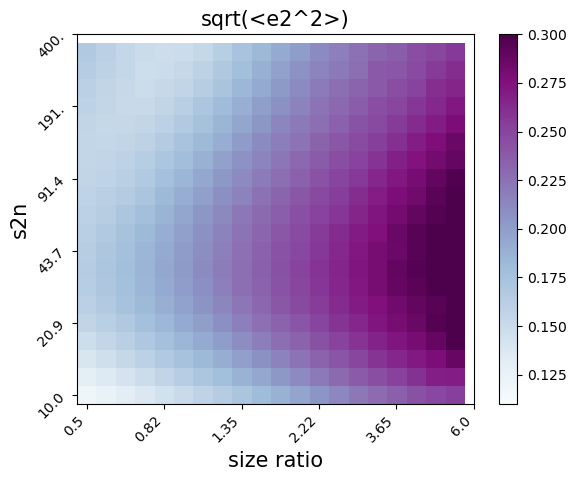

In [14]:
mplot.imshow(e2_grid.T, cmap='BuPu', origin='lower', aspect='auto')
mplot.xticks(np.arange(21)[::4], size_ratio_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.yticks(np.arange(21)[::4], s2n_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.title('sqrt(<e2^2>)', fontsize=15)
mplot.xlabel('size ratio', fontsize=15)
mplot.ylabel('s2n', fontsize=15)
mplot.colorbar()
mplot.clim(0.11,0.3)

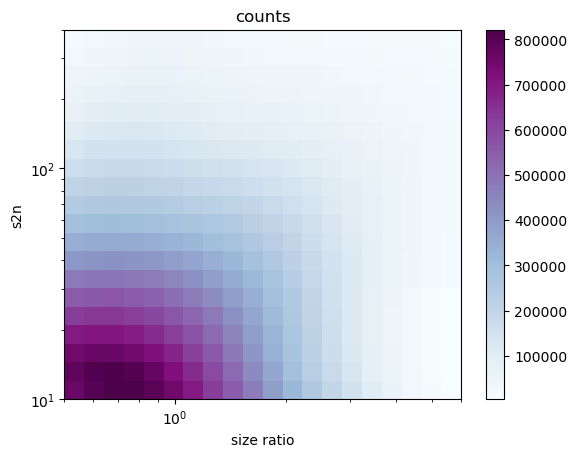

In [15]:
X = mplot.hist2d(size_ratio, s2n, bins=(size_ratio_grid, s2n_grid), cmap='BuPu')
mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('size ratio')
mplot.ylabel('s2n')
mplot.title('counts')
mplot.colorbar()

### Second way of doing weights

We calculate this in code/response_s2n_size, here is just reading in the values. Also save to file.

In [4]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]

In [5]:
size_ratio_grid = np.logspace(np.log10(0.5), np.log10(6), 21)
s2n_grid = np.logspace(np.log10(10), np.log10(400), 21)
size_ratio_grid2 = [str(xx)[:4] for xx in size_ratio_grid]
s2n_grid2 = [str(xx)[:4] for xx in s2n_grid]

In [6]:

counts = np.zeros((20,20))
sigma_e2 = np.zeros((20,20))
sigma_e2_m = np.zeros((20,20))
R11 = np.zeros((20,20))
R11s = np.zeros((20,20))
R22 = np.zeros((20,20))
R22s = np.zeros((20,20))

for i in range(20):
    for j in range(20):
        X = np.loadtxt('/project/chihway/chihway/shearcat/shear_catalog/response_s2n_size/response_'+str(i)+'_'+str(j)+'.txt')
        
        counts[i][j] = X[0]
        R11[i][j] = X[1]
        R11s[i][j] = X[2]
        R22[i][j] = X[3]
        R22s[i][j] = X[4]
        sigma_e2[i][j] = X[5]
        sigma_e2_m[i][j] = X[6]  

In [13]:
# counts
sigma_e2**0.5

array([[0.00013519, 0.00014543, 0.00016057, 0.00017765, 0.00019627,
        0.00021561, 0.00023556, 0.00025678, 0.00027736, 0.0002992 ,
        0.00032246, 0.00034856, 0.00038039, 0.00042234, 0.00047561,
        0.0005401 , 0.00063239, 0.0007494 , 0.0009076 , 0.00111053],
       [0.00013902, 0.00015044, 0.00016639, 0.00018408, 0.00020282,
        0.00022263, 0.0002429 , 0.0002636 , 0.00028312, 0.00030464,
        0.00032526, 0.0003492 , 0.00037558, 0.00040771, 0.00044725,
        0.00050229, 0.00056885, 0.000657  , 0.00078084, 0.00093388],
       [0.00014437, 0.0001572 , 0.0001743 , 0.00019237, 0.00021143,
        0.00023185, 0.00025264, 0.0002736 , 0.0002941 , 0.0003152 ,
        0.00033511, 0.00035702, 0.00038117, 0.00040578, 0.00044048,
        0.00048052, 0.00053192, 0.000603  , 0.00069193, 0.00080942],
       [0.00015188, 0.00016627, 0.00018409, 0.00020312, 0.00022358,
        0.00024397, 0.00026502, 0.00028747, 0.0003082 , 0.00032976,
        0.00035132, 0.00037215, 0.00039478, 0

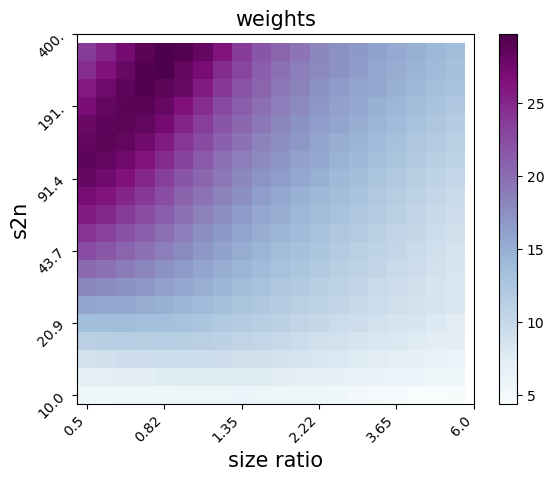

In [10]:
R_gamma = (R11+R22)/2
sigma_e_all = (sigma_e2*counts).copy()
ww = (1./(sigma_e_all*R_gamma**(-2))).T
mplot.imshow(ww, cmap='BuPu', origin='lower', aspect='auto')
mplot.xticks(np.arange(21)[::4], size_ratio_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.yticks(np.arange(21)[::4], s2n_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.title('weights', fontsize=15)
mplot.xlabel('size ratio', fontsize=15)
mplot.ylabel('s2n', fontsize=15)
mplot.colorbar()

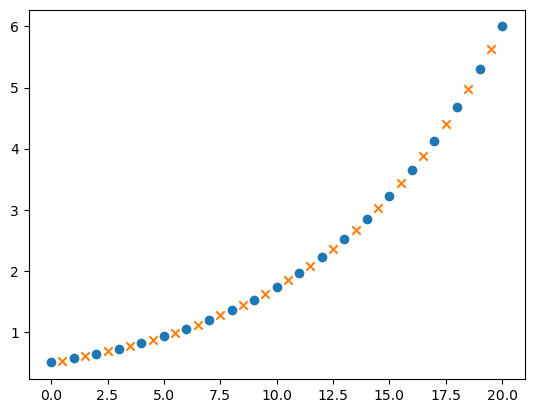

In [9]:
size_ratio_grid = np.logspace(np.log10(0.5), np.log10(6), 21)
size_ratio_grid_center = np.logspace(np.log10(0.5), np.log10(6), 41)[1:][::2]

s2n_grid = np.logspace(np.log10(10), np.log10(400), 21)
s2n_grid_center = np.logspace(np.log10(10), np.log10(400), 41)[1:][::2]

mplot.scatter(np.arange(21), size_ratio_grid)
mplot.scatter(np.arange(20)+0.5, size_ratio_grid_center, marker='x')

In [10]:
xx, yy = np.meshgrid(size_ratio_grid_center, s2n_grid_center)

In [11]:
from scipy.interpolate import griddata


In [12]:

w_v2 = griddata(np.array([xx.flatten(),yy.flatten()]).T, ww.flatten(), (size_ratio[:10000], s2n[:10000]), method='nearest')



(10, 100)

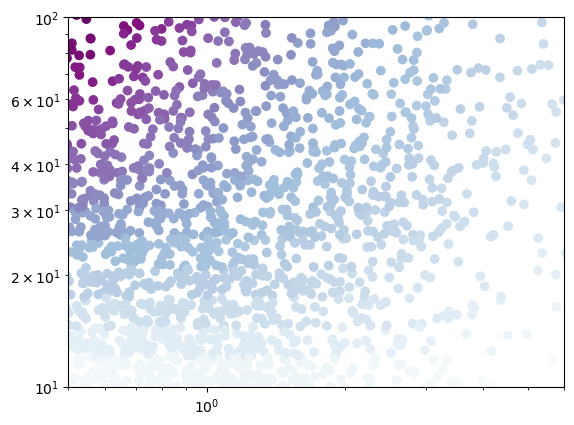

In [13]:
mplot.scatter(size_ratio[:10000], s2n[:10000], c=w_v2, cmap='BuPu')
mplot.xscale('log')
mplot.yscale('log')
mplot.xlim(0.5,6)
mplot.ylim(10,100)
# print(w_v2)


(array([2.49023593e+08, 6.91183870e+07, 2.14804220e+07, 7.98257600e+06,
        3.71123500e+06, 1.99721700e+06, 1.20446900e+06, 7.91038000e+05,
        5.54743000e+05, 4.10034000e+05, 3.16068000e+05, 2.53474000e+05,
        2.08585000e+05, 1.74787000e+05, 1.49506000e+05, 1.29262000e+05,
        1.14511000e+05, 1.01217000e+05, 9.13520000e+04, 8.26580000e+04,
        7.53320000e+04, 6.91690000e+04, 6.35110000e+04, 5.87400000e+04,
        5.46870000e+04, 5.14220000e+04, 4.79280000e+04, 4.47520000e+04,
        4.18570000e+04, 3.97160000e+04, 3.73400000e+04, 3.55120000e+04,
        3.38100000e+04, 3.17970000e+04, 3.05780000e+04, 2.87490000e+04,
        2.75100000e+04, 2.56900000e+04, 2.45990000e+04, 2.37710000e+04,
        2.25110000e+04, 2.15030000e+04, 2.08190000e+04, 1.99530000e+04,
        1.89280000e+04, 1.81130000e+04, 1.75810000e+04, 1.69890000e+04,
        1.64650000e+04, 1.57920000e+04, 1.52500000e+04, 1.44830000e+04,
        1.41230000e+04, 1.37430000e+04, 1.30090000e+04, 1.293500

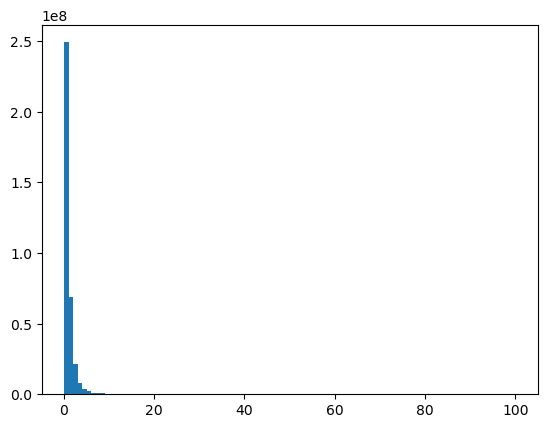

In [14]:
mplot.hist(size_ratio, bins=100, range=(0.1,100))

In [15]:
size_ratio = np.nan_to_num(size_ratio)
s2n = np.nan_to_num(s2n)

# size_ratio[size_ratio<=0.5] = 0.5
# size_ratio[size_ratio>=6.0] = 6.0
# s2n[s2n<=10] = 10.0
# s2n[s2n>=400] = 400.0


In [16]:
# w_v2 = griddata(np.array([xx.flatten(),yy.flatten()]).T, ww.flatten(), (size_ratio, s2n), method='nearest')

In [17]:
len(s2n)

597650947

In [18]:
w_v2 = []
for i in range(580):
    print(i)
    X = griddata(np.array([xx.flatten(),yy.flatten()]).T, ww.flatten(), (size_ratio[i*1000000:(i+1)*1000000], s2n[i*1000000:(i+1)*1000000]), method='nearest')
    w_v2.append(X)

X = griddata(np.array([xx.flatten(),yy.flatten()]).T, ww.flatten(), (size_ratio[580*1000000:], s2n[580*1000000:]), method='nearest')
w_v2.append(X)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [19]:
# X = (size_ratio[i*1000000:(i+1)*1000000])
# Y = np.nan_to_num(X)
# Y[Y==0]

In [20]:
new_w_v2 = np.concatenate(w_v2)
print(new_w_v2)

[28.57567889  5.33028433 23.70271047 ... 18.18111907 22.29811567
  5.33028433]


In [21]:
del w_v2

In [22]:
# mplot.hist(w_v2, bins=100)

In [23]:
len(new_w_v2), len(s2n)

(597650947, 597650947)

In [24]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'a') as h5r:
    del h5r['mcal_g_w_v2']
    h5r.create_dataset('mcal_g_w_v2', data = new_w_v2)

## Now once the file has all the columns, let's look at a rough fiducial sample

In [6]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    ra = h5r['RA'][:]
    dec = h5r['DEC'][:]

In [7]:
# nside = 4096
# map_counts = np.zeros(hp.nside2npix(nside))

# phi = ra/180*np.pi
# theta = (90.-dec)/180*np.pi

# pix = hp.ang2pix(nside, theta, phi)

In [8]:
nside = 4096
map_counts = np.zeros(hp.nside2npix(nside))

phi = ra[mask_total]/180*np.pi
theta = (90.-dec[mask_total])/180*np.pi

pix = hp.ang2pix(nside, theta, phi)

In [9]:
for i in range(len(pix)):
    map_counts[pix[i]] += 1

In [10]:
area = len(map_counts[map_counts>0])/len(map_counts)*4*np.pi*(180./np.pi)**2*60*60
print('area', area/60/60, 'deg^2')

area 5460.137711948227 deg^2


In [11]:
print('total', len(ra[mask_total])/area, '/arcmin^2')

total 5.540390836342204 /arcmin^2


In [12]:
len(ra[mask_total])

108904669

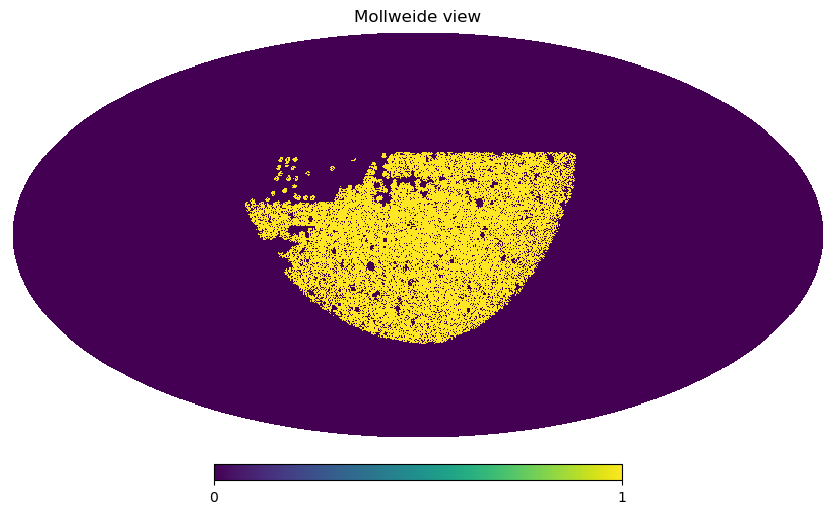

In [15]:
X = map_counts.copy()
X[X>0] = 1
hp.mollview(X, rot=[180,0])

## Calculate shear calibration

In [ ]:
Mask = {}

In [ ]:
for shear_type in ['noshear', '1p', '1m', '2p', '2m']: 
    with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
        sg = h5r['sg_bdf'][:] 
        fg = h5r['FLAGS_FOREGROUND'][:] 
        T = h5r['mcal_T_'+shear_type][:]
        s2n = h5r['mcal_s2n_'+shear_type][:]
        size_ratio = h5r['mcal_T_ratio_'+shear_type][:]
        mcal_flags = h5r['mcal_flags'][:]
        flux_r, flux_i, flux_z = h5r['mcal_flux_'+shear_type][:].T
        g1, g2  = h5r['mcal_g_'+shear_type][:].T
        
    mag_r = -2.5*np.log10(flux_r)+30
    mag_i = -2.5*np.log10(flux_i)+30
    mag_z = -2.5*np.log10(flux_z)+30

    # PZ mask
    mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                        (mag_r < 26)   & (mag_r > 15) & 
                        (mag_z < 26)   & (mag_z > 15) & 
                        (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                        (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

    # Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
    SNR_Mask   = (s2n > 10) & (s2n < 1000)
    Tratio_Mask= size_ratio > 0.5
    T_Mask = T < 10
    Flag_Mask = (mcal_flags == 0)
    Other_Mask = np.invert((T > 2) & (s2n < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))
    SG_Mask = (sg>=4)
    FG_Mask = (fg==0)

    mask_total_X = mcal_pz_mask & SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Other_Mask & SG_Mask & FG_Mask
    
    Mask[shear_type] = mask_total_X
    del T
    del s2n
    del size_ratio
    del sg
    del fg
    del flux_r, flux_i, flux_z
    del mag_r, mag_i, mag_z

In [ ]:
def weight_average(values, weights):
    return np.sum(values*weights)/np.sum(weights)

In [ ]:
dgamma = 2*0.01
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:

    R11 =  (weight_average(h5r['mcal_g_1p'][:,0][Mask['noshear']],h5r['mcal_g_w'][Mask['noshear']]) - weight_average(h5r['mcal_g_1m'][:,0][Mask['noshear']], h5r['mcal_g_w'][Mask['noshear']]))/dgamma
    R11s = (weight_average(h5r['mcal_g_noshear'][:,0][Mask['1p']], h5r['mcal_g_w'][Mask['1p']]) - weight_average(h5r['mcal_g_noshear'][:,0][Mask['1m']], h5r['mcal_g_w'][Mask['1m']]))/dgamma
    R22 =  (weight_average(h5r['mcal_g_2p'][:,1][Mask['noshear']], h5r['mcal_g_w'][Mask['noshear']]) - weight_average(h5r['mcal_g_2m'][:,1][Mask['noshear']], h5r['mcal_g_w'][Mask['noshear']]))/dgamma
    R22s = (weight_average(h5r['mcal_g_noshear'][:,1][Mask['2p']], h5r['mcal_g_w'][Mask['2p']]) - weight_average(h5r['mcal_g_noshear'][:,1][Mask['2m']], h5r['mcal_g_w'][Mask['2m']]))/dgamma
    R11tot = R11+R11s
    R22tot = R22+R22s
    
    print('R11', R11, 'R11s', R11s)
    print('R22', R22, 'R22s', R22s)
    print('R11tot', R11tot, 'R22tot', R22tot)

In [ ]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    R11 =  (weight_average(h5r['mcal_g_1p'][:,0][Mask['noshear']], h5r['mcal_g_w_v2'][Mask['noshear']]) - weight_average(h5r['mcal_g_1m'][:,0][Mask['noshear']], h5r['mcal_g_w_v2'][Mask['noshear']]))/dgamma
    R11s = (weight_average(h5r['mcal_g_noshear'][:,0][Mask['1p']], h5r['mcal_g_w_v2'][Mask['1p']]) - weight_average(h5r['mcal_g_noshear'][:,0][Mask['1m']], h5r['mcal_g_w_v2'][Mask['1m']]))/dgamma
    R22 =  (weight_average(h5r['mcal_g_2p'][:,1][Mask['noshear']], h5r['mcal_g_w_v2'][Mask['noshear']]) - weight_average(h5r['mcal_g_2m'][:,1][Mask['noshear']], h5r['mcal_g_w_v2'][Mask['noshear']]))/dgamma
    R22s = (weight_average(h5r['mcal_g_noshear'][:,1][Mask['2p']], h5r['mcal_g_w_v2'][Mask['2p']]) - weight_average(h5r['mcal_g_noshear'][:,1][Mask['2m']], h5r['mcal_g_w_v2'][Mask['2m']]))/dgamma
    R11tot = R11+R11s
    R22tot = R22+R22s
    
    print('R11', R11, 'R11s', R11s)
    print('R22', R22, 'R22s', R22s)
    print('R11tot', R11tot, 'R22tot', R22tot)


## Make a bunch of maps with noshear quantities from shear catalog

In [9]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    ra = h5r['RA'][:]
    dec = h5r['DEC'][:]
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    psf_e1, psf_e2 = h5r['mcal_psf_g_noshear'][:].T
    s2n = h5r['mcal_s2n_noshear'][:]
    w = h5r['mcal_g_w_v2'][:]

In [10]:
ra = ra[mask_total]
dec = dec[mask_total]
size_ratio = size_ratio[mask_total]
psf_e1 = psf_e1[mask_total]
psf_e2 = psf_e2[mask_total]
s2n = s2n[mask_total]
w = w[mask_total]

In [15]:
psf_e2.shape

(85757977,)

In [11]:
nside = 4096
map_counts = np.zeros(hp.nside2npix(nside))
map_weights = np.zeros(hp.nside2npix(nside))
map_psf_e1 = np.zeros(hp.nside2npix(nside))
map_psf_e2 = np.zeros(hp.nside2npix(nside))
map_size_ratio = np.zeros(hp.nside2npix(nside))
map_s2n = np.zeros(hp.nside2npix(nside))

phi = ra/180*np.pi
theta = (90.-dec)/180*np.pi

pix = hp.ang2pix(nside, theta, phi)

In [16]:
for i in range(len(pix)):
    map_counts[pix[i]] += 1
    map_weights[pix[i]] += w[i]
    map_size_ratio[pix[i]] += size_ratio[i]*w[i]
    map_s2n[pix[i]] += s2n[i]*w[i]
    map_psf_e1[pix[i]] += psf_e1[i]*w[i]
    map_psf_e2[pix[i]] += psf_e2[i]*w[i]

In [17]:
# plot bright stars on mask to see if it's working as intended
f = pf.open('/project/chihway/dhayaa/DECADE/bsc5p_bright_stars.fits')[1].data

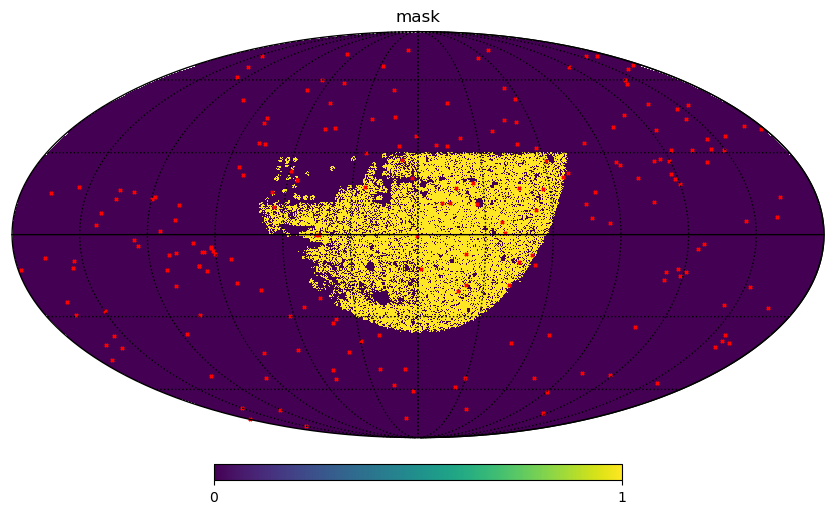

In [40]:
mask_fid = map_counts.copy()
mask_fid[mask_fid>0] = 1
hp.mollview(mask_fid, title='mask', rot=[180,0])
# hp.cartview(mask_fid, lonra=[90,180], latra=[-50,35],title='mask')
hp.projscatter(f['ra'], f['dec'], lonlat = True, s = 5, marker='x', color = 'r', rot=[180,0])
hp.graticule()
mplot.savefig('mask.pdf')

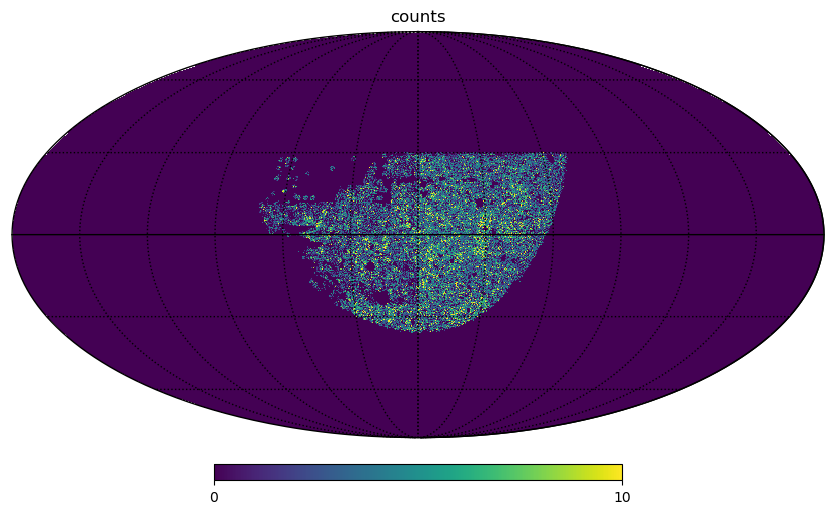

In [41]:
# hp.cartview(map_counts, lonra=[90,180], latra=[-30,35], min=0, max=10, title='counts')
hp.mollview(map_counts, rot=[180,0], min=0, max=10, title='counts')
hp.graticule()
mplot.savefig('counts.pdf')

/home/chihway/ipykernel_341480/2976308858.py:2: RuntimeWarning: invalid value encountered in divide
  hp.mollview(map_size_ratio/map_weights, rot=[180,0], min=0, max=2, title='size ratio')


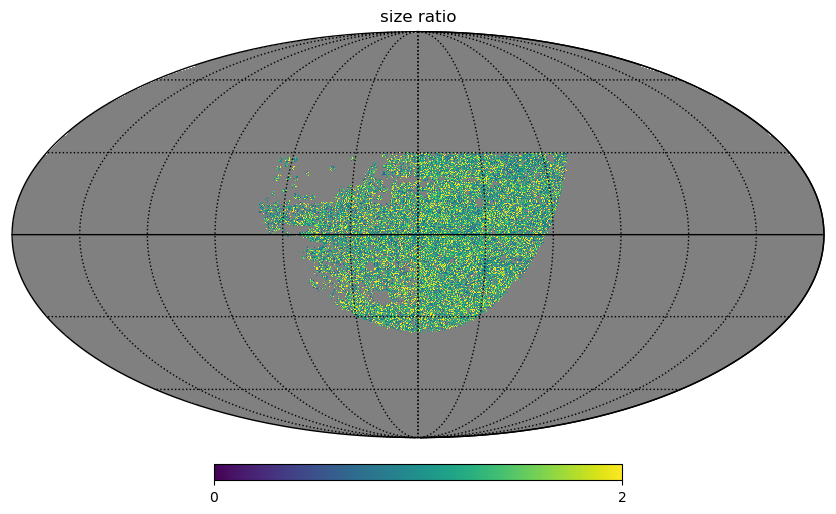

In [43]:
# hp.cartview(map_size_ratio/map_weights, lonra=[90,180], latra=[-30,35], min=0, max=2, title='size ratio')
hp.mollview(map_size_ratio/map_weights, rot=[180,0], min=0, max=2, title='size ratio')
hp.graticule()
mplot.savefig('size.pdf')

/home/chihway/ipykernel_341480/2805055171.py:2: RuntimeWarning: invalid value encountered in divide
  hp.mollview(map_s2n/map_weights, rot=[180,0], min=0, max=100, title='s2n')


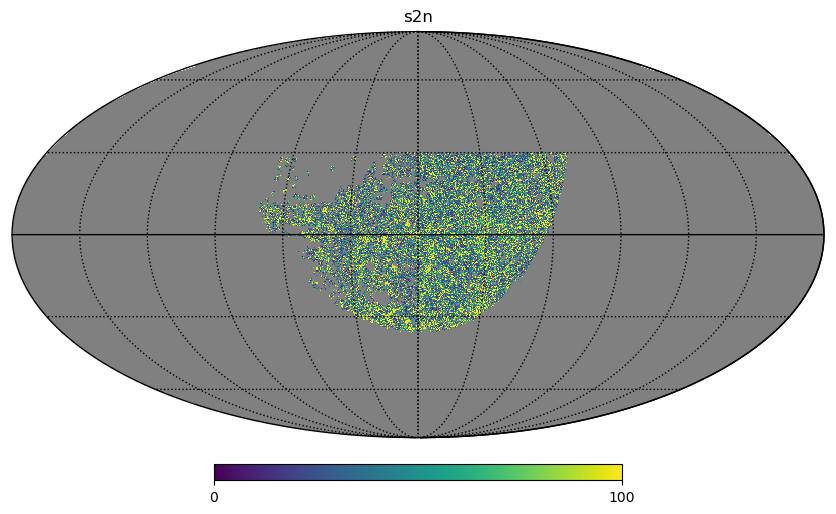

In [44]:
# hp.cartview(map_s2n/map_weights, lonra=[90,180], latra=[-30,35], min=0, max=100, title='s2n')
hp.mollview(map_s2n/map_weights, rot=[180,0], min=0, max=100, title='s2n')

hp.graticule()
mplot.savefig('s2n.pdf')

/home/chihway/ipykernel_341480/2720332926.py:2: RuntimeWarning: invalid value encountered in divide
  hp.mollview(map_psf_e1/map_weights, rot=[180,0],title='psf_e1')


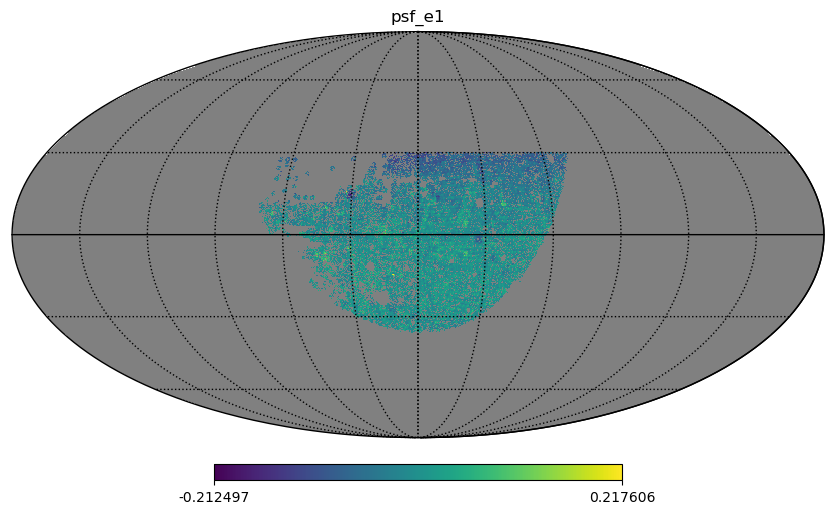

In [47]:
# hp.cartview(map_psf_e1/map_weights, lonra=[90,180], latra=[-30,35], title='PSF e1')
hp.mollview(map_psf_e1/map_weights, rot=[180,0],title='psf_e1')

hp.graticule()
mplot.savefig('psfe1.pdf')

/home/chihway/ipykernel_341480/3943052994.py:2: RuntimeWarning: invalid value encountered in divide
  hp.mollview(map_psf_e2/map_weights, rot=[180,0],title='psf_e2')


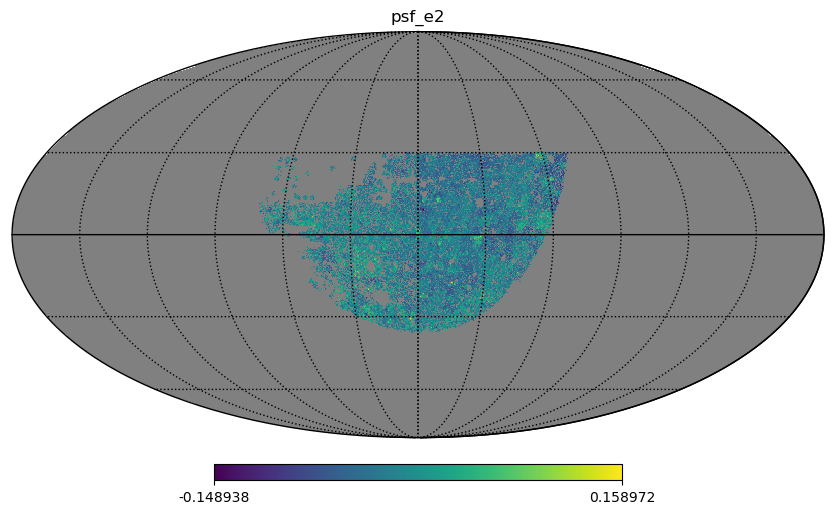

In [48]:
# hp.cartview(map_psf_e2/map_weights, lonra=[90,180], latra=[-30,35], title='PSF e2')
hp.mollview(map_psf_e2/map_weights, rot=[180,0],title='psf_e2')

hp.graticule()
mplot.savefig('psfe2.pdf')

In [26]:
def divide_map(map1, map2):
    outmap = map1.copy()
    outmap[map2>0] /= map2[map2>0]
    outmap[map2==0] = hp.UNSEEN
    return outmap

In [28]:
map_dir = '/project/chihway/data/decade/SP_maps/mcal/'
hp.write_map(map_dir+'ncounts_2023'+tag+'.fits', map_counts, overwrite=True)
hp.write_map(map_dir+'psf_e1_2023'+tag+'.fits', divide_map(map_psf_e1,map_weights), overwrite=True)
hp.write_map(map_dir+'psf_e2_2023'+tag+'.fits', divide_map(map_psf_e2,map_weights), overwrite=True)
hp.write_map(map_dir+'size_ratio_2023'+tag+'.fits', divide_map(map_size_ratio,map_weights), overwrite=True)
hp.write_map(map_dir+'s2n_2023'+tag+'.fits', divide_map(map_s2n,map_weights), overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


## Some investigation of the gridding pattern in the PSF ellipticity maps

/tmp/jobs/27624000/ipykernel_38902/3181526985.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.cartview(map_psf_e1/map_counts, lonra=[120,180], latra=[-20,0], title='PSF e1')


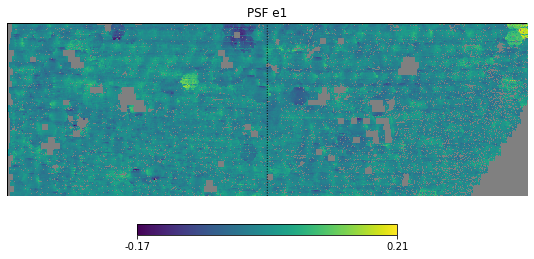

In [15]:
hp.cartview(map_psf_e1/map_counts, lonra=[120,180], latra=[-20,0], title='PSF e1')
hp.graticule()

/tmp/jobs/27624000/ipykernel_38902/1825602356.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.cartview(map_psf_e2/map_counts, lonra=[90,180], latra=[-30,35], title='PSF e2')


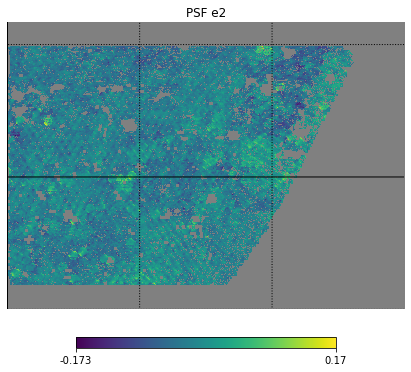

In [16]:
hp.cartview(map_psf_e2/map_counts, lonra=[90,180], latra=[-30,35], title='PSF e2')
hp.graticule()

In [17]:
tile_list = pf.open('/project2/chihway/data/decade/decam-tiles-bliss-v1.fits.gz')

In [18]:
print(tile_list[1].header.keys)

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   26 / width of table in bytes                        
NAXIS2  =                63488 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    8 / number of fields in each row                   
TTYPE1  = 'TILEID  '           / label for field   1                            
TFORM1  = 'J       '           / data format of field: 4-byte INTEGER           
TTYPE2  = 'PASS    '           / label for field   2                            
TFORM2  = 'I       '           / data format of field: 2-byte INTEGER           

In [19]:
mask = (tile_list[1].data['pass']==1)
ra_tile = tile_list[1].data['ra'][mask]
dec_tile = tile_list[1].data['dec'][mask]
print(tile_list[1].data['pass'])

[1 1 1 ... 4 4 4]


/tmp/jobs/27624000/ipykernel_38902/1288674342.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.cartview(map_psf_e1/map_counts, lonra=[90,180], latra=[-30,35], title='PSF e1')


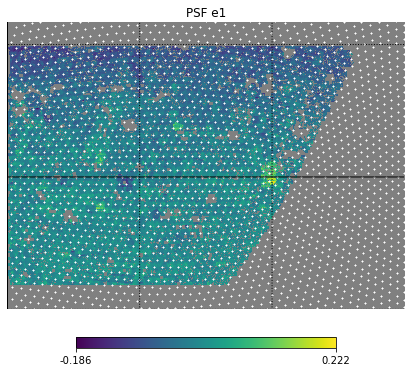

In [39]:
hp.cartview(map_psf_e1/map_counts, lonra=[90,180], latra=[-30,35], title='PSF e1')
#hp.mollview(map_psf_e1/map_counts)
hp.projscatter(ra_tile, dec_tile, color='w', s=1, marker='x', lonlat=True)
hp.graticule()

In [55]:
ids = np.arange(len(ra_map[map_counts>0]))
np.random.shuffle(ids)

/tmp/jobs/27624000/ipykernel_38902/1664470758.py:3: RuntimeWarning: invalid value encountered in true_divide
  mplot.hist2d(ra_map[map_counts>0][ids[:300000]], dec_map[map_counts>0][ids[:300000]], weights=(map_psf_e1/map_counts)[map_counts>0][ids[:300000]], bins=(500,400))


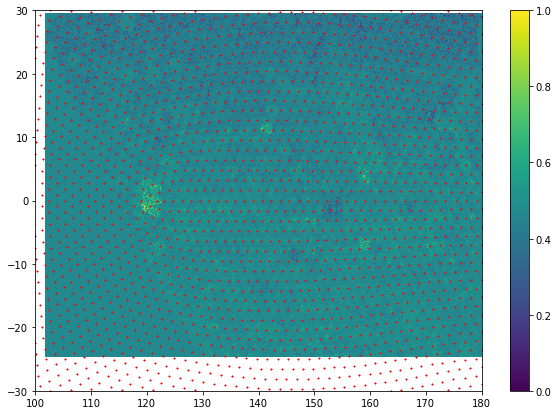

In [72]:
mplot.figure(figsize=(10,7))
# mplot.scatter(ra_map[map_counts>0][ids[:300000]], dec_map[map_counts>0][ids[:300000]], c=(map_psf_e1/map_counts)[map_counts>0][ids[:300000]], s=1, marker='.')
mplot.hist2d(ra_map[map_counts>0][ids[:300000]], dec_map[map_counts>0][ids[:300000]], weights=(map_psf_e1/map_counts)[map_counts>0][ids[:300000]], bins=(500,400))

mplot.scatter(ra_tile, dec_tile, color='r', s=1, marker='x')
mplot.xlim(100,180)
mplot.ylim(-30,30)
mplot.colorbar()

In [51]:
len(map_counts), len(ra_map)

(201326592, 59919130)

## check if similar gridding patterns are in Y1

In [25]:
desy1 = pf.open('/project2/chihway/data/des_y1_catalogs/mcal-y1a1-combined-riz-unblind-v4-matched.fits')
desy1[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  614 / width of table in bytes                        
NAXIS2  =            136930995 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   80 / number of fields in each row                   
TTYPE1  = 'coadd_objects_id'   / label for field   1                            
TFORM1  = 'K       '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'flags   '           / label for field   2                            
TFORM2  = 'J       '           / data format of field: 4-byte INTEGER           
TTYPE3  = 'mask_frac'       

In [26]:
mask = (desy1[1].data['flags']==0)
ra_mask = desy1[1].data['ra'][mask]
dec_mask = desy1[1].data['dec'][mask]
psf_e1_mask = desy1[1].data['psf_e1'][mask]
psf_e2_mask = desy1[1].data['psf_e2'][mask]

In [27]:
nside = 4096
map_counts = np.zeros(hp.nside2npix(nside))
map_psf_e1 = np.zeros(hp.nside2npix(nside))
map_psf_e2 = np.zeros(hp.nside2npix(nside))

phi = ra_mask/180*np.pi
theta = (90.-dec_mask)/180*np.pi

pix = hp.ang2pix(nside, theta, phi)

In [28]:
for i in range(len(pix)):
    map_counts[pix[i]] += 1
    map_psf_e1[pix[i]] += psf_e1_mask[i]
    map_psf_e2[pix[i]] += psf_e2_mask[i]
 

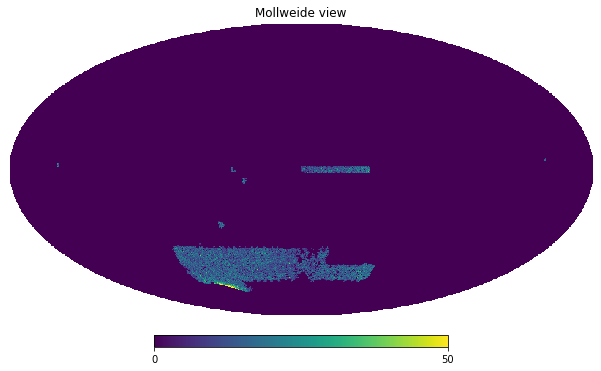

In [29]:
hp.mollview(map_counts,min=0,max=50)

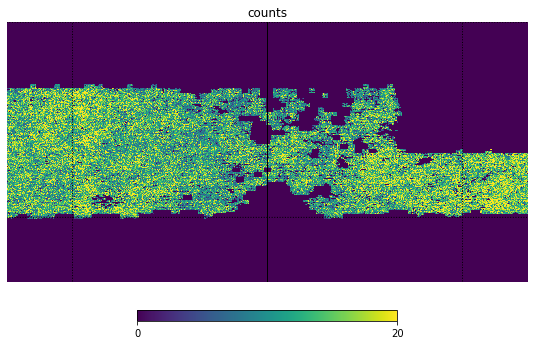

In [30]:
hp.cartview(map_counts, lonra=[-40,40], latra=[-70,-30], min=0, max=20, title='counts')
hp.graticule()

/tmp/jobs/27622198/ipykernel_6734/1944693814.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.cartview(map_psf_e1/map_counts, lonra=[-40,40], latra=[-60,-40], title='psf e1')


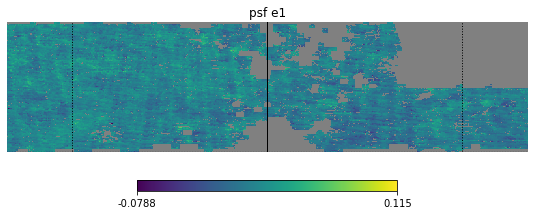

In [92]:

hp.cartview(map_psf_e1/map_counts, lonra=[-40,40], latra=[-60,-40], title='psf e1')
hp.graticule()

/tmp/jobs/27622198/ipykernel_6734/2151345328.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.cartview(map_psf_e2/map_counts, lonra=[-40,40], latra=[-60,-40], title='psf e1')


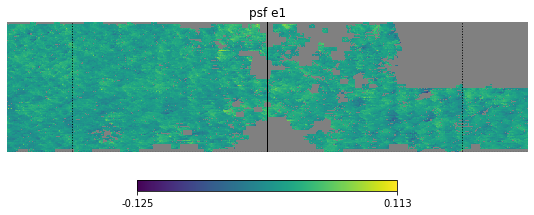

In [93]:
hp.cartview(map_psf_e2/map_counts, lonra=[-40,40], latra=[-60,-40], title='psf e1')
hp.graticule()